# Sentiment Time Series Generation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import ast
from transformers import pipeline
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2023-01-15 19:55:37.581544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-15 19:55:37.581577: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [3]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,40043,"[""When I'm lyin' in my bed at night"", ""I don't...",rock,40043,"[""When I'm lyin' with my sisters face first"", ...","['Every night I hope and pray', 'A dream lover..."
1,48922,"['Love is like problems', ""We all got 'em"", 'A...",rock,48922,"['Love spreads like magic', ""We seriously need...","['You can be amazing', 'You can turn a phrase ..."
2,41840,"[""As I was motivatin'"", 'Back in town', 'I saw...",rock,41840,"[""As Katrina was ''"", 'Back to town', 'I saw t...","[""I love it when we're cruisin' together"", ""I ..."
3,39964,"['Oh love, oh love', ""Won't you rain on me ton...",rock,39964,"['Oh my, no love', ""Won't you rain down it too...","['Galleria:', 'When I was just a little girl',..."
4,37806,"['Take my breath away', ""I don't need it anywa...",rock,37806,"['Take you breath carefully', 'I kinda want it...","['Tuesday seemed like it was thursday', 'Yeste..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           150 non-null    int64 
 1   lyrics          150 non-null    object
 2   genre           150 non-null    object
 3   id              150 non-null    int64 
 4   similar_lyrics  150 non-null    object
 5   random_lyrics   150 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.2+ KB


In [5]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))
df['similar_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['similar_lyrics']))
df['random_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['random_lyrics']))

In [6]:
eg_lyrics = random.choice(df['lyrics'])
eg_lyrics

["I rhyme rhyme, that's why I shine shine,",
 'and you can roll anyone of my shows,',
 'no lights in my bag no eye sight',
 "I gotta keep on ryhmin' man,",
 'so i keep on shinin man',
 'I aint gonna be a one hit wonder,',
 'I am forever, call me diamond man,',
 "I've been talkin' 'bout my new diamond rings",
 "because my new diamond rings they're the shit",
 "oh oh oh you've been talkin' 'bout my new diamond rings",
 'because my new diamond rings,',
 "they're what's in",
 "and if you're looking at me,",
 "you gon' be looking at them",
 'cause there the swagger that you see in my walk',
 "and if you're listening to me,",
 "you gon' be listening to them",
 'cause theyre the slick that you hear in my talk',
 'Hit me one screen, West End',
 " shine like I'm a girl's best friend ",
 "girls see me and scream cause I'm on the tv,",
 'but i still take walks in my ends',
 '14 when i entered the game',
 'All i wanted was a little bit of fame ',
 "and now I'm f*ckin with the grown-ups",
 'go mad 

In [7]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"I wake up every morning, with the sun in my eyes",verse
1,"I stumble out of bed, and I hit the ground run...",verse
2,"I've got a lot on my plate, but I don't mind t...",verse
3,"I know I've got what it takes, to make it down...",verse
4,"I'm living for today, and I'm chasing my dreams",chorus


In [8]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['I wake up every morning, with the sun in my eyes',
 'I stumble out of bed, and I hit the ground running',
 "I've got a lot on my plate, but I don't mind the load",
 "I know I've got what it takes, to make it down the road",
 "I'm living for today, and I'm chasing my dreams",
 "I won't let anyone stand in my way, or burst at the seams",
 "I'm on a mission, to reach for the stars",
 "I'm unstoppable, behind the steering wheel of my car",
 "I hit the pavement, and I don't look back",
 "I've got my foot on the gas, and I'm on the right track",
 "I know I've got what it takes, to make it to the top",
 "I won't stop until I reach the mountaintop",
 "I'm living for today, and I'm chasing my dreams",
 "I won't let anyone stand in my way, or burst at the seams",
 "I'm on a mission, to reach for the stars",
 "I'm unstoppable, behind the steering wheel of my car",
 "I've got my eyes on the prize, and I won't let it go",
 "I'll keep on fighting, with all my might and my mojo"]

## Sentiment Time Series

In [9]:
sent_pipeline = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")

In [10]:
sentences = ['I love you', 'I hate you', 'I am going to the store to buy some milk.']

model_output = sent_pipeline(sentences)
model_output

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079},
 {'label': 'NEGATIVE', 'score': 0.9932184815406799}]

In [11]:
def get_unique_sentiment(sentiment_output):
    # Map sentiment in a unique value ranging [-1,1]
    unique_sentiments = []
    for so in sentiment_output:
        if so['label'] == 'POSITIVE':
            pos = so['score']
            neg = 1 - pos
        else:
            neg = so['score']
            pos = 1- neg
        unique_sentiments.append(pos - neg)
    return unique_sentiments

In [12]:
unique_scores = get_unique_sentiment(model_output)
list(zip(sentences, unique_scores))


[('I love you', 0.9997313022613525),
 ('I hate you', -0.9982258081436157),
 ('I am going to the store to buy some milk.', -0.9864369630813599)]

In [13]:
eg_sentibert_ts = get_unique_sentiment(sent_pipeline(eg_lyrics))

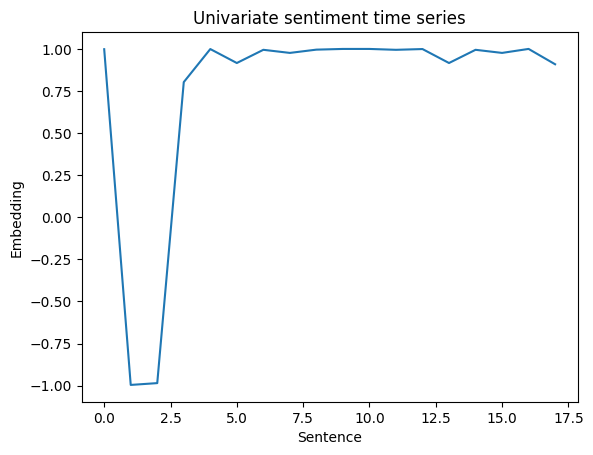

In [14]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_sentibert_ts)
ax.set_xlabel('Sentence')
ax.set_ylabel('Embedding')
ax.set_title('Univariate sentiment time series')
plt.show()

In [15]:
sentibert_ts = [get_unique_sentiment(sent_pipeline(lyrics)) for lyrics in tqdm(df['lyrics'])]

100%|██████████| 150/150 [08:25<00:00,  3.37s/it]


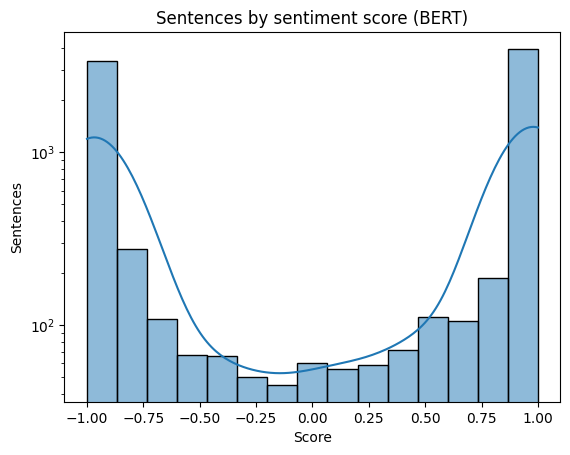

In [16]:
bert_scores = [score for sb_ts in sentibert_ts for score in sb_ts]

fig, ax = plt.subplots()
ax = sns.histplot(bert_scores, kde=True)
ax.set_xlabel('Score')
ax.set_ylabel('Sentences')
ax.set_yscale('log')
ax.set_title('Sentences by sentiment score (BERT)')

plt.show()

In [17]:
# VADER model
sid = SentimentIntensityAnalyzer()

for sentence in sentences:
    print(sentence, sid.polarity_scores(sentence)['compound'])

I love you 0.6369
I hate you -0.5719
I am going to the store to buy some milk. 0.0


In [18]:
generate_vader_ts = lambda lyrics: [sid.polarity_scores(verse)['compound'] for verse in lyrics]

eg_sentivader_ts = generate_vader_ts(eg_lyrics)

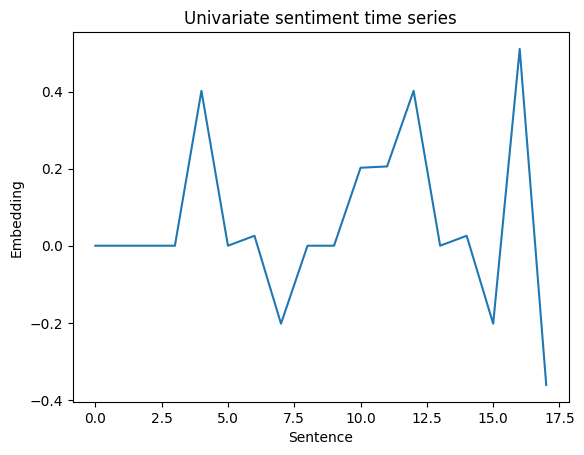

In [19]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_sentivader_ts)
ax.set_xlabel('Sentence')
ax.set_ylabel('Embedding')
ax.set_title('Univariate sentiment time series')
plt.show()

In [20]:
vader_sen_ts = []

for lyrics in tqdm(df['lyrics']):
    vader_sen_ts.append([sid.polarity_scores(verse)['compound'] for verse in lyrics])

100%|██████████| 150/150 [00:00<00:00, 201.35it/s]


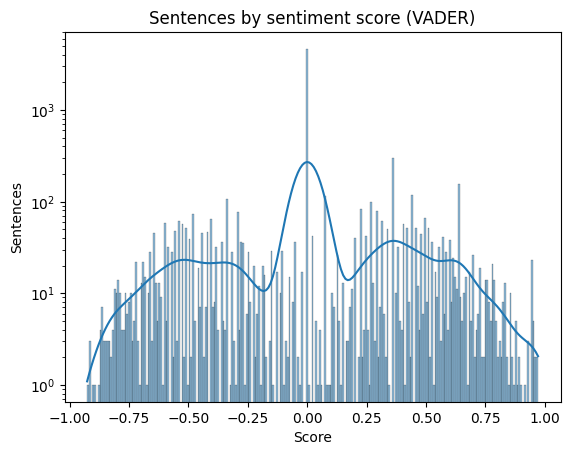

In [21]:
vader_scores = [score for vst in vader_sen_ts for score in vst]

fig, ax = plt.subplots()
ax = sns.histplot(vader_scores, kde=True)
ax.set_xlabel('Score')
ax.set_ylabel('Sentences')
ax.set_title('Sentences by sentiment score (VADER)')
ax.set_yscale('log')
plt.show()

correlation: 0.3777431289563501


<AxesSubplot: xlabel='vader', ylabel='bert'>

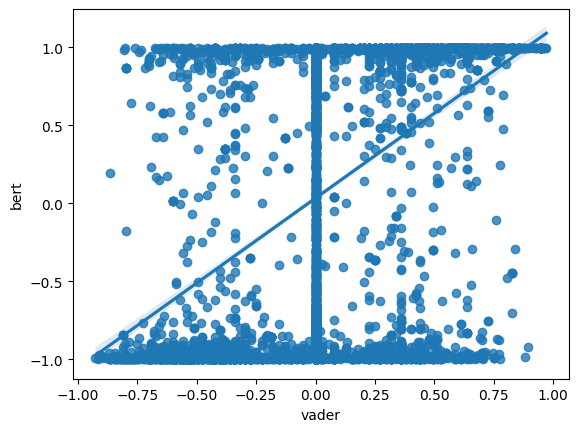

In [22]:
data = {'vader': vader_scores, 'bert': bert_scores}
scores = pd.DataFrame(data)
corr = np.corrcoef(vader_scores, data['bert'])[0, 1]

print(f'correlation: {corr}')

sns.regplot(data=scores, x='vader', y='bert')

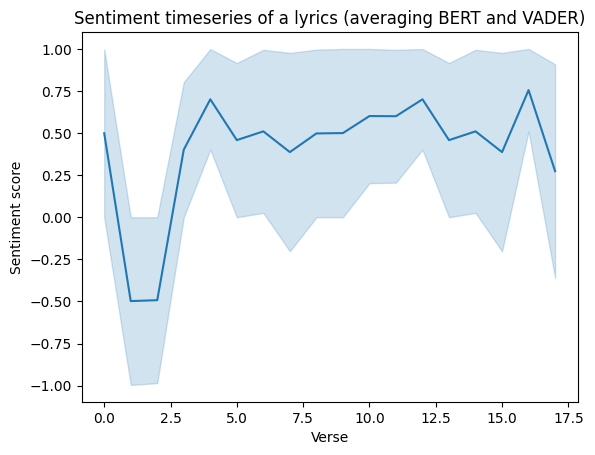

In [23]:
data = {'sentiment': eg_sentibert_ts + eg_sentivader_ts,
        'model': ['bert'] * len(eg_sentibert_ts) + ['vader'] * len(eg_sentivader_ts),
        'timestamp': [count for count, value in enumerate(eg_sentibert_ts)] + [count for count, value in enumerate(eg_sentivader_ts)]}

eg_sent_ts = pd.DataFrame(data)


fig, ax = plt.subplots()
#ax = sns.lineplot(data=eg_sent_ts, x='timestamp', y='sentiment', hue='model')
ax = sns.lineplot(data=eg_sent_ts, x='timestamp', y='sentiment')
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
#ax.set_title('Sentiment timeseries')
ax.set_title('Sentiment timeseries of a lyrics (averaging BERT and VADER)')
plt.show()

In [24]:
eg_sen_ts = np.mean(np.column_stack((eg_sentibert_ts, eg_sentivader_ts)), axis=1)
eg_sen_ts.shape

(18,)

In [25]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    print(lyrics_type)
    ts_data[lyrics_type] = []
    for lyr in tqdm(df[lyrics_type]):
        sentibert_ts = get_unique_sentiment(sent_pipeline(lyr))
        sentivader_ts = generate_vader_ts(lyr)
        sentiment_ts = np.mean(np.column_stack((sentibert_ts, sentivader_ts)), axis=1)
        sentiment_ts = list(sentiment_ts)
        ts_data[lyrics_type].append(sentiment_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/sentiment_ts.csv'
ts_data.to_csv(filename, index=False)
print('___')

lyrics


100%|██████████| 150/150 [09:15<00:00,  3.70s/it]


similar_lyrics


100%|██████████| 150/150 [09:44<00:00,  3.89s/it]


random_lyrics


100%|██████████| 150/150 [08:00<00:00,  3.20s/it]

___


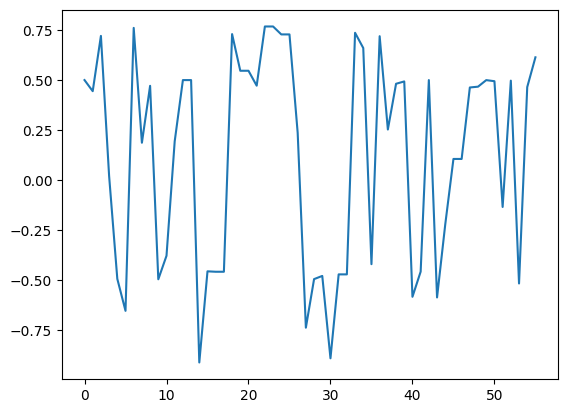

In [26]:
plt.plot(random.choice(ts_data['similar_lyrics']))

## Emotion Time Series

In [27]:
emo_pipeline = pipeline(model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

In [28]:
sentences = ["I am so happy right now!",            
            "What a beautiful surprise!.",
            "This news made me feel so worried.",
            "I am so excited for my vacation!",
            "I am feeling really calm and content.",
            "That smell is making me feel so disgusted."]

model_output = emo_pipeline(sentences)
model_output

[[{'label': 'joy', 'score': 0.9736263751983643},
  {'label': 'surprise', 'score': 0.014337554574012756},
  {'label': 'sadness', 'score': 0.007655743975192308},
  {'label': 'neutral', 'score': 0.0022524443920701742},
  {'label': 'anger', 'score': 0.0014425611589103937},
  {'label': 'disgust', 'score': 0.0003827261971309781},
  {'label': 'fear', 'score': 0.0003024883335456252}],
 [{'label': 'joy', 'score': 0.5090370774269104},
  {'label': 'surprise', 'score': 0.44889599084854126},
  {'label': 'neutral', 'score': 0.024029050022363663},
  {'label': 'sadness', 'score': 0.007921875454485416},
  {'label': 'anger', 'score': 0.005217096768319607},
  {'label': 'fear', 'score': 0.0033160680904984474},
  {'label': 'disgust', 'score': 0.0015828609466552734}],
 [{'label': 'fear', 'score': 0.9896484017372131},
  {'label': 'anger', 'score': 0.002574719488620758},
  {'label': 'sadness', 'score': 0.0021302204113453627},
  {'label': 'neutral', 'score': 0.002073839074000716},
  {'label': 'surprise', 'scor

In [29]:
def get_emotions_ts(emotion_output, emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']):    
    # Get emotions scores stored in a dictionary
    emotion_scores = {}
    # Compose dictionary with entries
    for emotion in emotions:
        emotion_scores[emotion] = []
    for eo_list in emotion_output:
        for eo_dict in eo_list:
            label = eo_dict['label']
            score = eo_dict['score']
            emotion_scores[label].append(score)    
    return emotion_scores

In [30]:
eg_emotion_output = emo_pipeline(eg_lyrics)
eg_multi_ts = pd.DataFrame(get_emotions_ts(eg_emotion_output))
eg_multi_ts

,anger,disgust,fear,joy,neutral,sadness,surprise
0,0.031320,0.020962,0.204004,0.033034,0.425419,0.146509,0.138752
1,0.013357,0.004577,0.722702,0.003333,0.023584,0.043760,0.188687
2,0.107708,0.187861,0.003651,0.030616,0.640628,0.026488,0.003048
3,0.009671,0.006610,0.006898,0.011374,0.950715,0.008280,0.006452
4,0.033649,0.005708,0.015025,0.419227,0.322868,0.196006,0.007518
5,0.923573,0.002361,0.061592,0.001784,0.006587,0.002584,0.001518
6,0.034898,0.003441,0.413755,0.105303,0.327023,0.052429,0.063150
7,0.022479,0.004099,0.182613,0.420891,0.169534,0.006479,0.193907
8,0.183989,0.050625,0.412746,0.003342,0.070566,0.174051,0.104681
9,0.013157,0.004366,0.007259,0.019729,0.935045,0.005241,0.015203


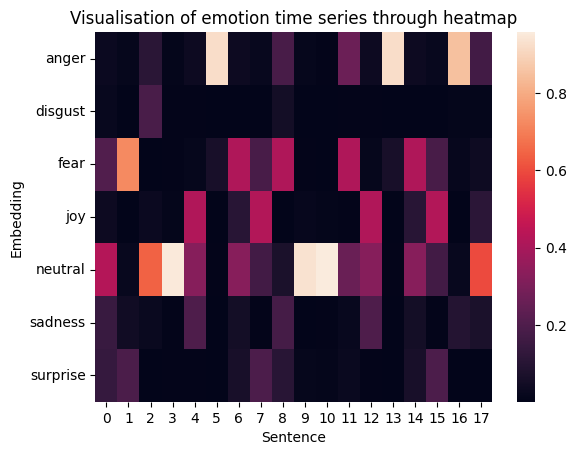

In [31]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('Sentence')
ax.set_ylabel('Embedding')
ax.set_title('Visualisation of emotion time series through heatmap')
plt.show() 

In [32]:
ss = StandardScaler()
pca = PCA(n_components=1, random_state=0)

eg_norm_multi_ts = ss.fit_transform(eg_multi_ts)

eg_unipca_ts = np.array([pc[0] for pc in pca.fit_transform(eg_norm_multi_ts)])

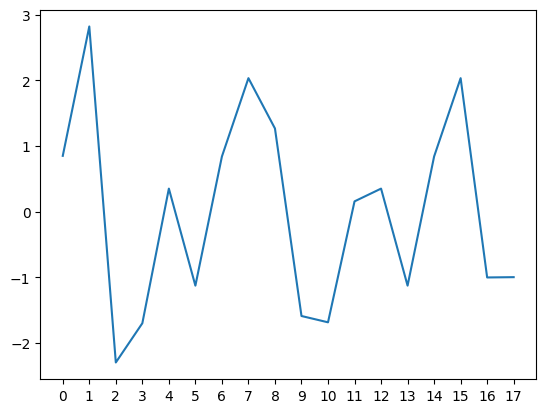

In [33]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_unipca_ts)
# Draw dots representing parts of the lyrics
ax.set_xticks(range(len(eg_unipca_ts)))
plt.show()

In [34]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    print(lyrics_type)
    ts_data[lyrics_type] = []
    for lyr in tqdm(df[lyrics_type]):
        emotion_output = emo_pipeline(lyr)
        multi_ts = pd.DataFrame(get_emotions_ts(emotion_output))
        ss = StandardScaler()
        pca = PCA(n_components=1, random_state=0)
        norm_multi_ts = ss.fit_transform(multi_ts)
        unipca_ts = np.array([pc[0] for pc in pca.fit_transform(norm_multi_ts)])
        unipca_ts = list(unipca_ts)
        ts_data[lyrics_type].append(unipca_ts)
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/emotion_pca_ts.csv'
ts_data.to_csv(filename, index=False)
print('___')

lyrics


100%|██████████| 150/150 [08:45<00:00,  3.50s/it]


similar_lyrics


100%|██████████| 150/150 [10:08<00:00,  4.06s/it]


random_lyrics


100%|██████████| 150/150 [08:58<00:00,  3.59s/it]

___
